In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [234]:
# 1) Load data
df = pd.read_csv("titanic (1).csv")
# Quick view
print(df.head())
print(df.info())
print(df.isna().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [235]:
# 2) Basic preprocessing: drop high-cardinality / ID-like columns
df = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

# Handle missing numerical values (Age, Fare)
for col in ["Age", "Fare"]:
    df[col] = df[col].fillna(df[col].median())

# Handle missing categorical values (Embarked)
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0]) 

# Encode categorical variables: Sex, Embarked(one-hot)
df["Sex"] = df["Sex"].map({"male": 0, "female": 1}).astype(int)

embarked_dummies = pd.get_dummies(df["Embarked"], prefix="Embarked")
df = pd.concat([df.drop(columns=["Embarked"]), embarked_dummies], axis=1)
print(df.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0         0       3    0  22.0      1      0   7.2500       False       False   
1         1       1    1  38.0      1      0  71.2833        True       False   
2         1       3    1  26.0      0      0   7.9250       False       False   
3         1       1    1  35.0      1      0  53.1000       False       False   
4         0       3    0  35.0      0      0   8.0500       False       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  


In [236]:
# 3) Feature selection
# Target
y = df["Survived"].values.reshape(-1, 1)
X = df.drop(columns=["Survived"])
# Optional: correlation check (for analysis only)
corr = df.corr(numeric_only=True)
print(corr["Survived"].sort_values(ascending=False))

Survived      1.000000
Sex           0.543351
Fare          0.257307
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.064910
Embarked_S   -0.149683
Pclass       -0.338481
Name: Survived, dtype: float64


In [237]:
# 4) Train/test split (80/20) 
from math import floor

np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = floor(0.8 * len(X))
train_idx, test_idx = indices[:train_size], indices[train_size:]

X_train = X.iloc[train_idx].values
y_train = y[train_idx]
X_test = X.iloc[test_idx].values
y_test = y[test_idx]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (712, 9) (712, 1)
Test shape: (179, 9) (179, 1)


In [238]:
# 5) Standardization 
# Standardize using training statistics only
def standardize(train, test):
    train = np.asarray(train, dtype=float)
    test = np.asarray(test, dtype=float)

    mean = train.mean(axis=0, keepdims=True)
    std = train.std(axis=0, keepdims=True)
    std[std == 0] = 1.0
    train_std = (train - mean) / std
    test_std = (test - mean) / std
    return train_std, test_std, mean, std

X_train_std, X_test_std, X_mean, X_std = standardize(X_train, X_test)
def add_bias(X):
    X = np.asarray(X, dtype=float)
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train_b = add_bias(X_train_std)
X_test_b = add_bias(X_test_std)

n_samples, n_features = X_train_b.shape
print("With bias:", X_train_b.shape)

With bias: (712, 10)


Iter 0: cost = 0.693147
Iter 100: cost = 0.457808
Iter 200: cost = 0.447098
Iter 300: cost = 0.445091
Iter 400: cost = 0.444538
Iter 500: cost = 0.444357
Iter 600: cost = 0.444293
Iter 700: cost = 0.444269
Early stopping at iteration 736, cost change 0.00000010
Final cost: 0.44426511248916595
Iterations run: 737


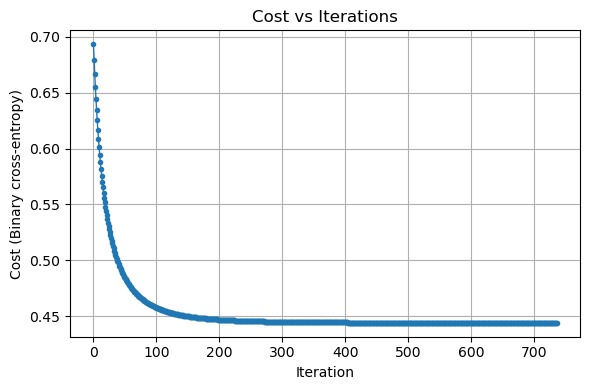

In [239]:
# 6) Logistic regression from scratch
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def compute_cost(X, y, w, lam=0.0):
    m = X.shape[0]
    z = X @ w
    h = sigmoid(z)

    eps = 1e-15
    h = np.clip(h, eps, 1 - eps)

    cost = - (1.0 / m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))
    reg = (lam / (2.0 * m)) * np.sum(w[1:] ** 2)
    cost_scalar = cost.item()
    reg_scalar = float(reg)
    return cost_scalar + reg_scalar

def compute_gradient(X, y, w, lam=0.0):
    m = X.shape[0]
    z = X @ w
    h = sigmoid(z)

    grad = (1.0 / m) * (X.T @ (h - y))
    reg = (lam / m) * w
    reg[0] = 0.0
    return grad + reg

def gradient_descent(X, y, lr=0.1, num_iters=750, lam=0.0, tol=1e-7):
    n = X.shape[1]
    w = np.zeros((n, 1))
    costs = []

    for i in range(num_iters):
        cost = compute_cost(X, y, w, lam)
        costs.append(cost)

        grad = compute_gradient(X, y, w, lam)
        w = w - lr * grad

        if i > 0 and abs(costs[-2] - costs[-1]) < tol:
            print(f"Early stopping at iteration {i}, cost change {abs(costs[-2] - costs[-1]):.8f}")
            break

        if i % 100 == 0:
            print(f"Iter {i}: cost = {cost:.6f}")

    return w, np.array(costs)

# Train main model
initial_lr = 0.1
max_iters = 750
lam = 0.01

w_learned, cost_history = gradient_descent(
    X_train_b, y_train, lr=initial_lr, num_iters=max_iters, lam=lam
)

print("Final cost:", cost_history[-1])
print("Iterations run:", len(cost_history))

# Cost vs iterations graph
plt.figure(figsize=(6, 4))
plt.plot(range(len(cost_history)), cost_history, marker="o", markersize=3, linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("Cost (Binary cross-entropy)")
plt.title("Cost vs Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()


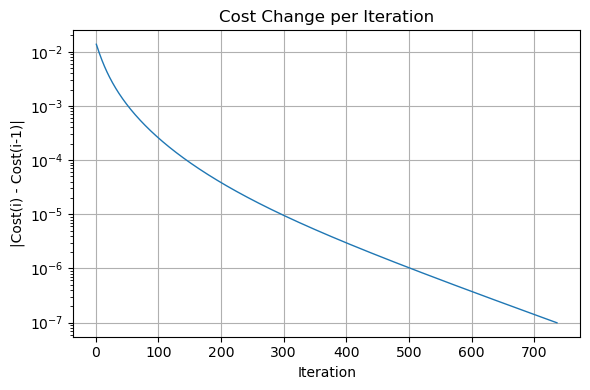

In [240]:
# Optionally inspect where it stagnates (e.g., change < small epsilon)
cost_diff = np.abs(np.diff(cost_history))
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cost_history)), cost_diff, linewidth=1)
plt.xlabel("Iteration")
plt.ylabel("|Cost(i) - Cost(i-1)|")
plt.title("Cost Change per Iteration")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()

In [241]:
# 7) Metrics (accuracy, precision, recall, F1, confusion matrix)

def predict_proba(X, w):
    return sigmoid(X @ w)

def predict_class(X, w, threshold=0.5):
    proba = predict_proba(X, w)
    return (proba >= threshold).astype(int)

def confusion_matrix(y_true, y_pred):
    """
    Returns: TP, FP, FN, TN
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, fp, fn, tn

def classification_metrics(y_true, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    return accuracy, precision, recall, f1, (tp, fp, fn, tn)



In [242]:
# 8) Train predictions + evaluation
# ---------------------------------------
y_train_pred = predict_class(X_train_b, w_learned)
y_test_pred = predict_class(X_test_b, w_learned)

train_acc, train_prec, train_rec, train_f1, train_cm = classification_metrics(
    y_train, y_train_pred
)
test_acc, test_prec, test_rec, test_f1, test_cm = classification_metrics(
    y_test, y_test_pred
)


print("Train metrics:")
print(f"Accuracy: {train_acc:.4f}, \nPrecision: {train_prec:.4f}, \nRecall: {train_rec:.4f}, \nF1: {train_f1:.4f}")
print("Confusion matrix (TP, FP, FN, TN):", train_cm)

print("\nTest metrics:")
print(f"Accuracy: {test_acc:.4f}, \nPrecision: {test_prec:.4f}, \nRecall: {test_rec:.4f}, \nF1: {test_f1:.4f}")
print("Confusion matrix (TP, FP, FN, TN):", test_cm)

Train metrics:
Accuracy: 0.7978, 
Precision: 0.7491, 
Recall: 0.7220, 
F1: 0.7353
Confusion matrix (TP, FP, FN, TN): (np.int64(200), np.int64(67), np.int64(77), np.int64(368))

Test metrics:
Accuracy: 0.7821, 
Precision: 0.6970, 
Recall: 0.7077, 
F1: 0.7023
Confusion matrix (TP, FP, FN, TN): (np.int64(46), np.int64(20), np.int64(19), np.int64(94))


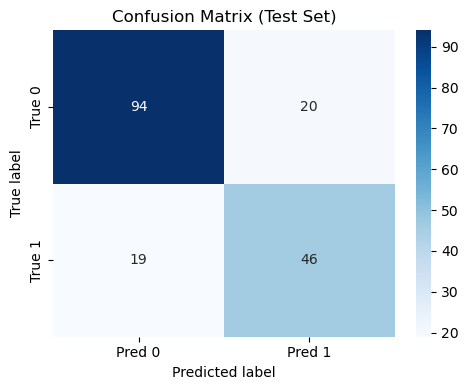

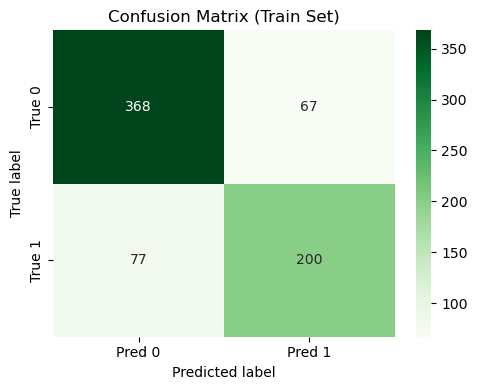

In [243]:
# 9a) Visualize confusion matrix (test set)
tp, fp, fn, tn = test_cm
cm_matrix = np.array([[tn, fp],
                      [fn, tp]])

plt.figure(figsize=(5, 4))
sns.heatmap(cm_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Test Set)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

tp_tr, fp_tr, fn_tr, tn_tr = train_cm
cm_train = np.array([[tn_tr, fp_tr],
                     [fn_tr, tp_tr]])

plt.figure(figsize=(5, 4))
sns.heatmap(cm_train,
            annot=True,
            fmt="d",
            cmap="Greens",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (Train Set)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


Iter 0: cost = 0.693147
Iter 100: cost = 0.623797
Iter 200: cost = 0.620476
Iter 300: cost = 0.619966
Iter 400: cost = 0.619863
Early stopping at iteration 499, cost change 0.00000010


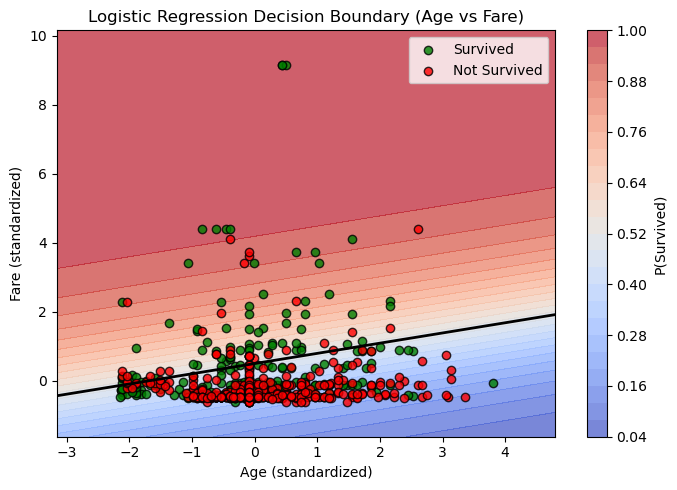

In [244]:
# 9c) Decision boundary plot
feat_x = "Age"
feat_y = "Fare"

# Select only these two features
X_vis = df[[feat_x, feat_y]].values
y_vis = y

# Standardize
X_vis_train, X_vis_test, _, _ = standardize(X_vis[train_idx], X_vis[test_idx])

X_vis_train_b = add_bias(X_vis_train)
X_vis_test_b = add_bias(X_vis_test)

# Train 2D logistic regression
w_vis, cost_vis = gradient_descent(
    X_vis_train_b, y_train, lr=0.1, num_iters=550, lam=0.01, tol=1e-7
)

# Create mesh grid in standardized feature space
x_min, x_max = X_vis_train[:, 0].min() - 1, X_vis_train[:, 0].max() + 1
y_min, y_max = X_vis_train[:, 1].min() - 1, X_vis_train[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

grid = np.c_[xx.ravel(), yy.ravel()]
grid_b = add_bias(grid)
proba_grid = predict_proba(grid_b, w_vis).reshape(xx.shape)

plt.figure(figsize=(7, 5))
# Contour for decision boundary at 0.5
cs = plt.contourf(xx, yy, proba_grid, levels=25, cmap="coolwarm", alpha=0.7)
plt.colorbar(cs, label="P(Survived)")
plt.contour(xx, yy, proba_grid, levels=[0.5], colors="k", linewidths=2)

# Scatter points (training set only, in standardized coordinates)
survived_idx = (y_train.flatten() == 1)
not_survived_idx = (y_train.flatten() == 0)

plt.scatter(
    X_vis_train[survived_idx, 0],
    X_vis_train[survived_idx, 1],
    c="green", edgecolor="k", label="Survived", alpha=0.8
)
plt.scatter(
    X_vis_train[not_survived_idx, 0],
    X_vis_train[not_survived_idx, 1],
    c="red", edgecolor="k", label="Not Survived", alpha=0.8
)

plt.xlabel(f"{feat_x} (standardized)")
plt.ylabel(f"{feat_y} (standardized)")
plt.title("Logistic Regression Decision Boundary (Age vs Fare)")
plt.legend()
plt.tight_layout()
plt.show()